# Pre-processing

# Evaluating the responses of LLMs and Human

Importing Libraries

In [ ]:
!pip install pandas
!pip install transformers
!pip install sentence-transformers
!
!pip install nltkpip install bert-score
!pip  install rouge-score
!pip install -U evaluate
!pip install torch


import pandas as pd
import torch
from sentence_transformers import SentenceTransformer
from bert_score import BERTScorer
from rouge_score import rouge_scorer
from nltk.translate import meteor_score
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import evaluate


: 

## Defining the evaluation functions

In [ ]:
from rouge_score import rouge_scorer
from bert_score import BERTScorer
from nltk.translate import meteor_score
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModelForSequenceClassification


def cosine_similarity_score(sentences1, sentences2):
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    embeddings1 = model.encode(sentences1, convert_to_tensor=True)
    embeddings2 = model.encode(sentences2, convert_to_tensor=True)
    cos_scores = util.pytorch_cos_sim(embeddings1, embeddings2)

    # Move tensors from GPU to CPU
    cos_scores_cpu = cos_scores.cpu()

    return cos_scores_cpu.numpy().diagonal()



def rouge_l_score(sentence1, sentence2):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_score = scorer.score(sentence1, sentence2)['rougeL'].fmeasure
    return rouge_score


def bert_score(sentences1, sentences2):
    results = bertscore.compute(predictions=[sentences1], references=[sentences2],model_type='bert-base-uncased', lang="en")

    return results['f1'][0]

def calculate_bleu_4(candidate, reference):
    """
    Calculate BLEU-4 score between a candidate translation and a reference translation.

    Args:
        candidate (str): Candidate translation string.
        reference (str): Reference translation string.

    Returns:
        float: BLEU-4 score.
    """
    def get_ngram_counts(sentence, n):
        """
        Calculate n-gram counts for a given sentence.
        """
        ngram_counts = Counter()
        words = sentence.split()
        for i in range(len(words)):
            for j in range(1, n + 1):
                if i + j <= len(words):
                    ngram = ' '.join(words[i:i + j])
                    ngram_counts[ngram] += 1
        return ngram_counts

    def compute_bleu_4(candidate, reference):
        """
        Compute BLEU-4 score between a candidate translation and a reference translation.
        """
        candidate_len = len(candidate.split())
        reference_len = len(reference.split())
        precision = 0.0
        n = 4  # BLEU-4 specific
        for i in range(1, n + 1):
            candidate_ngrams = get_ngram_counts(candidate, i)
            reference_ngrams = get_ngram_counts(reference, i)
            common_ngrams = sum(min(candidate_ngrams[ngram], reference_ngrams[ngram]) for ngram in candidate_ngrams)
            precision += common_ngrams / max(1, candidate_len - i + 1)
        precision /= n
        if precision == 0:
            return 0.0  # Avoiding math domain error when precision is zero
        brevity_penalty = min(1, math.exp(1 - reference_len / candidate_len))
        bleu = brevity_penalty * math.exp(math.log(precision) / n)
        return bleu

    return compute_bleu_4(candidate, reference)


#It was previously used in our pipeline. Finally it was not considered for analysis as it is closely similar to BERT
def bleurt_score(reference_texts, candidate_texts, model_name="Elron/bleurt-large-512", max_length=1084):
    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)  # Move the model to GPU

    # Compute BLEURT score
    with torch.no_grad():
        tokenized_inputs = tokenizer(
            reference_texts, candidate_texts,
            truncation=True, mabert_scorex_length=max_length, padding=True,
            return_tensors='pt'
        ).to(device)  # Move input tensors to GPU
        scores = model(**tokenized_inputs)[0].squeeze().cpu()  # Move scores back to CPU
    return scores

In [ ]:
import pandas as pd

# Assuming your DataFrame is named 'df'
# df = pd.read_csv('full_article.csv')
# df = pd.read_csv('partial_article.csv')
df = pd.read_csv('qa_log_med.csv')

df = df.astype(str)
df.head()

,timestamp,question,answer,actual,model_name,prompt_technique
0,2024-05-13 20:26:25,You are a prolific medical document reviewer. ...,"Based on the provided context, there is no se...",Outcome Measures:\n\nPrimary Outcome Measure:\...,mistral:7b-instruct,base
1,2024-05-13 20:26:27,You are a prolific medical document reviewer. ...,"Based on the provided context, there is no sp...",Outcome Measures:\nPrimary Outcome Measure:\n1...,mistral:7b-instruct,base
2,2024-05-13 20:26:28,You are a prolific medical document reviewer. ...,"Based on the provided context, there is no se...",Outcome Measures:\nPrimary Outcome Measure:\n1...,mistral:7b-instruct,base
3,2024-05-13 20:26:29,You are a prolific medical document reviewer. ...,"Based on the provided context, there is no se...",Outcome Measures:\nPrimary Outcome Measure:\n1...,mistral:7b-instruct,base
4,2024-05-13 20:26:30,You are a prolific medical document reviewer. ...,"Based on the provided context, there is no se...",Outcome Measures:\nPrimary Outcome Measure:\n1...,mistral:7b-instruct,base


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   timestamp         110 non-null    object
 1   question          110 non-null    object
 2   answer            110 non-null    object
 3   actual            110 non-null    object
 4   model_name        110 non-null    object
 5   prompt_technique  110 non-null    object
dtypes: object(6)
memory usage: 5.3+ KB


In [ ]:
def remove_simple_strings(text):
    strings_to_remove = ["[", "]", "ReACT-"]
    for string in strings_to_remove:
        text = text.replace(string, "")
    return text


def remove_non_number_lines(text):
    lines = text.split('\n')
    number_lines = [line for line in lines if line.strip() and line.strip()[0].isdigit()]
    return '\n'.join(number_lines)

# Example usage
text = '''
Based on the provided article, here are some actionable recommendations for enhancing the sustainability of open-source software projects:

1. Foster a dynamic and self-reproducing OSS community.
2. Cultivate an inclusive environment that encourages newcomers to move toward the center of the community through continual contributions.
3. Prioritize responsiveness to newcomers' questions and contributions to sustain their interest and encourage further participation.

By implementing these actioanswernable recommendations, open-source software projects can enhance their sustainability and ensure their continued success.

'''


result = remove_non_number_lines(text)
print(result)

1. Foster a dynamic and self-reproducing OSS community.
2. Cultivate an inclusive environment that encourages newcomers to move toward the center of the community through continual contributions.
3. Prioritize responsiveness to newcomers' questions and contributions to sustain their interest and encourage further participation.


In [ ]:
import pandas as pd

# Assuming your DataFrame is named 'df'
result = pd.DataFrame(columns=['model', 'prompt_technique', 'Bleu4', 'CosineSim', 'RougeL', 'Bert'])

# Iterate over unique combinations of 'model' and 'prompting_technique'
for model in df['model_name'].unique():
    for technique in df[df['model_name'] == model]['prompt_technique'].unique():
        # print("hello")
        # print(model)
        # print(technique)
        sum_bleu4 = 0
        sum_cosine = 0
        sum_bert = 0
        sum_rouge = 0
        k=0
        # Iterate over rows corresponding to the current model and prompting technique
        for index, row in df[(df['model_name'] == model) & (df['prompt_technique'] == technique)].iterrows():
            k+=1

            row['actual'] = remove_simple_strings(row['actual'])
            row['answer'] = remove_non_number_lines(row['answer'])

            # print(row['actual'])
            print(row['answer'])
            if(row['answer']!=None and row['actual']!=None):
              sum_bleu4+=calculate_bleu_4(row['actual'], row['answer'])
              sum_cosine+=cosine_similarity_score(row['actual'], row['answer'])
              sum_bert+=bert_score(row['actual'], row['answer'])
              sum_rouge+=rouge_l_score(row['actual'], row['answer'])

        avg_bleu4 = sum_bleu4/k
        avg_cosine = sum_cosine/k
        avg_rouge =  sum_rouge/k
        avg_bert = sum_bert/k
        new_row = {'model': model, 'prompt_technique': technique, 'Bleu4': avg_bleu4, 'CosineSim': avg_cosine,'RougeL':avg_rouge, 'Bert':  avg_bert}
        result.loc[len(result)] = new_row

 Based on the provided context, there is no section or information directly related to a medical document with protocol ID 55321 and its outcome measures. The context only includes data from a software project and neuropsychological test measurements. Therefore, I cannot extract any outcome measures for the given medical document.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


 Based on the provided context, there is no specific section or subsection labeled as "Outcome Measures" for protocol ID 1114637. The context only mentions various tests and measurements used in different time frames, but it does not provide a clear list of outcome measures specifically related to this protocol ID. Therefore, I cannot extract the information you are asking for from the given context.
 Based on the provided context, there is no section or subsection labeled with the protocol ID 1787419 that discusses "Outcome Measures." Therefore, I cannot extract any information from the document regarding this topic for that specific ID. Please check if there's a mistake in the provided ID or if there's more context to consider.
 Based on the provided context, there is no section or information related to a medical document with protocol ID 1846783 that includes "Outcome Measures" presented in an unordered list format. Therefore, I cannot extract and present that information from the 

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


 Sure, I can extract the "Outcome Measures" section from the provided context for protocol ID 1114637 and present them in an unordered list format:

* WAIS-IV Digit Span Forward & Backward (measuring auditory attention and working memory)
* Verbal Fluency, Phonemic & Semantic (measuring verbal fluency by a word generation task based on letter and category)
* Stroop Color and Word Test; Word, Color & Word-Color (measuring reading speed, naming speed, and selective attention and inhibition)

Please note that the above measures are to be assessed pre-operatively and 12 months after index screening/date of surgery.
 Based on the provided context, there are no "Outcome Measures" related to the protocol ID 1787419 mentioned in the document. The only mention of any protocol ID is related to the data model of an open-source software project and not relevant to medical outcomes.

Here are the details from the context that mention the protocol ID:

* A data model of an open source software proje

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Based on the provided context, I have extracted the "Outcome Measures" section for protocol ID 1114637. Here are the measures listed in an unordered list format:

1. WAIS-IV Digit Span Forward & Backward
	* Auditory Attention (Forward)
	* Auditory attention and working memory (Backward)
2. WAIS-IV Digit Span Forward & Backward (pre-operatively)
	* Auditory Attention (Forward)
	* Auditory attention and working memory (Backward)
3. Verbal Fluency, Phonemic & Semantic
	* Verbal fluency by a word generation task based on letter & category (executive functioning)
4. Stroop Color and Word Test; Word, Color & Word-Color
	* Reading speed (word)
	* Naming speed (processing)
	* Selective attention and inhibition (attention/executive functioning)
5. Verbal Fluency, Phonemic & Semantic (pre-operatively)
	* Verbal fluency by a word generation task based on letter & category (executive functioning)
6. Stroop Color and Word Test; Word, Color & Word-Color (pre-operatively)
	* Reading speed (word)
	* N

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


 Sure, I'd be happy to help! Here are the outcome measures from the provided medical document, with each measure listed in an unordered list format for clarity:

Outcome Measures:

1. WAIS-IV Digit Span Forward & Backward: Measures auditory attention and working memory.
2. Verbal Fluency, Phonemic & Semantic: Measures verbal fluency by a word generation task based on letter and category (executive functioning).
3. Stroop Color and Word Test; Word, Color & Word-Color: Measures reading speed (word), naming speed (processing), and selective attention and inhibition (attention/executive functioning).
4. Cognitive Status: Assesses cognitive function, including memory, language, visuospatial skills, and executive functions.
5. Mental Health: Evaluates symptoms of depression, anxiety, and other mental health conditions that may impact cognitive function.
6. Quality of Life: Assesses the patient's subjective experience of their quality of life, including physical, emotional, and social well-be

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[INST]<<SYS>>


After reading the provided context, I found that there are no "Outcome Measures" mentioned with a unique protocol ID of 11,14637. The text appears to be discussing a data model for an open-source software project and includes information about cognitive tests used in a study.

However, I did find some sections related to cognitive tests, which might be relevant to your request. Here are the extracted results:

**Cognitive Tests:**

* 6. WAIS-IV Digit Span Forward & Backward
	+ Measures auditory Attention (Forward), and Auditory attention and working memory (Backward)
* [Time Frame: Pre-operatively]
* [Time Frame: 12 months after Index screening/date of surgery]
* 8. Verbal Fluency, Phonemic & Semantic
	+ Measures verbal fluency by a word generation task based on letter & category (executive functioning)
* [Time Frame: Pre-operatively]
* [Time Frame: 12 months after index screening/date of surgery]
* 10. Stroop Color and Word Test; Word, Color & Word-Color
	+ Measures re

In [ ]:
result.to_csv("results.csv")
result

,model,prompt_technique,Bleu4,CosineSim,RougeL,Bert
0,mistral:7b-instruct,base,0.376406,[0.26089323],0.091897,0.442465
1,mixtral:8x7b-instruct-v0.1-q4_K_M,base,0.359598,[0.36387455],0.108555,0.479178
2,llama2:latest,base,0.354823,[0.35289443],0.099599,0.488009
3,llama2:13b-chat,base,0.365886,[0.3437052],0.092781,0.476363
4,llama3:8b-instruct-q4_K_M,base,0.297536,[0.30569053],0.101952,0.470659


## Bar Plot with error graph

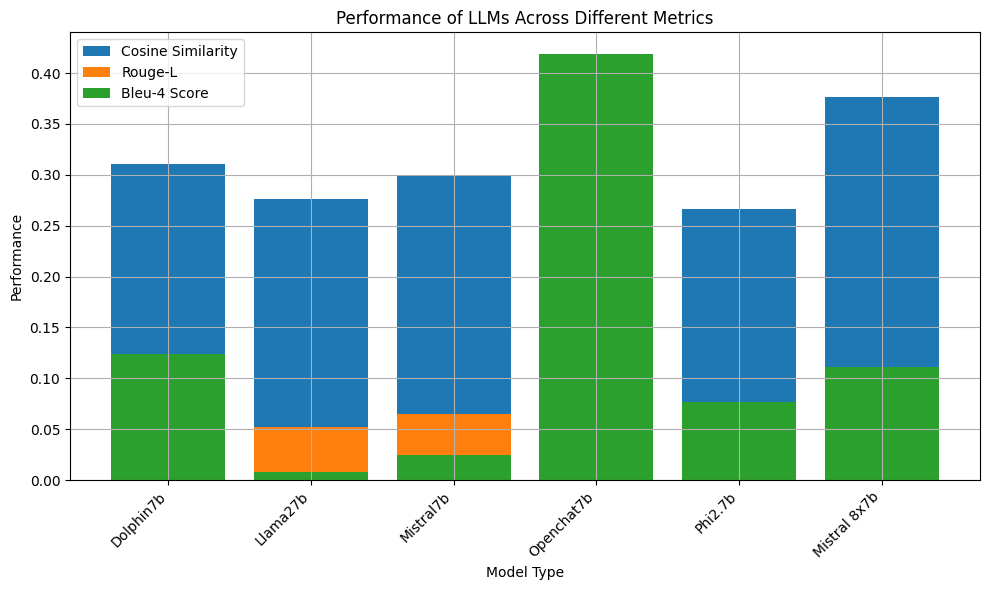

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for column in ['Cosine Similarity', 'Rouge-L', 'Bleu-4 Score']:
    plt.bar(sc['Model Type'], sc[column], label=column)

plt.xlabel('Model Type')
plt.ylabel('Performance')
plt.title('Performance of LLMs Across Different Metrics')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for column in ['Cosine Similarity', 'Rouge-L', 'Bleurt Score']:
    plt.bar(sc['Model Type'], sc[column], marker='o', label=column)

plt.xlabel('Model Type')
plt.ylabel('Performance')
plt.title('Performance of LLMs Across Different Metrics')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df["Standard"].shape[0]

10

In [ ]:
df["Standard"][0]

'[ReACT-1: Ensure a team of active and friendly developers.], \n[ReACT-2: Include the new members in the project, leveraging their prior experience.], \n[ReACT-3: Utilize a common programming language].\n[ReACT-4: Leverage widely-accepted software engineering principles.],\n[ReACT-5        Utilize a pull-based development approach.]\n[ReACT-6        Maintaining Continuous Integration]\n[ReACT-7        Maintain well-designed code.]\n[ReACT-8        Engage in code revision.]\n[ReACT-9        Grant newcomer access to the main repository.]\n[ReACT-10        Offer job support to the newcomer.]\n[ReACT-11        Keep the project small and simple.]\n[ReACT-12        Incorporate an open-source license.]\n[ReACT-13        Provide rewards to keep newcomers motivated.]'

In [ ]:
sc = sc.reset_index(drop=True)
sc

,Model Type,Cosine Similarity,Rouge-L,Bleurt Score
0,Llama-2-7B-Chat-GGML,0.636192,0.444511,0.876836
1,Mistral-7B-Instruct-v0.1-GGUF,0.223391,0.060427,0.816567
2,Dolphin-2.6-mistral-7B-GGUF,0.385079,0.184252,0.837000
3,Llama-2-13b-Chat-GGUF,0.295608,0.064249,0.813775
4,Gemma 7b,0.501767,0.494621,0.878641
5,wizard-3b-evol-instuct-v2-196k-GGUF,0.222364,0.052454,0.800737
6,Bing GPT 4,0.501245,0.367865,0.869963
7,Phi:Chat 2.7b,0.284973,0.071444,0.817925
8,neural-chat:7b,0.645801,0.524377,0.897507


## SPOT CHECKS

In [ ]:
import math
from collections import Counter



# Example usage:
candidate_translation = "[Hi qwer]"
reference_translation = "[Hi]"
bleu_4_score = calculate_bleu_4(candidate_translation, reference_translation)
print("BLEU-4 score:", bleu_4_score)

## Extracting the Coverage and Average Confidence Score


In [ ]:
#This function will extract coverage and average confidence score from the LLM generated response. We will run this after we are done with generating all the responses
import re

corpus = """
1. Encourage newcomers to participate in open source projects by making the system architecture modularized, offering many relatively independent tasks with progressive difficulty (Confidence level: 0.9). This allows newcomers to start participating peripherally and move on gradually to take charge of more difficult tasks.
2. Create an environment and culture that fosters a sense of belonging to the community and mechanisms that encourage and enable newcomers to move toward the center of the community through continual contributions (Confidence level: 0.8). Responsiveness to questions and contributions from newcomers is crucial for sustaining their interest and encouraging further participation.
3. Design systems with a high degree of openness in both product and process dimensions, providing more learning opportunities and making it easier for others to participate legitimately (Confidence level: 0.7). However, this may also reduce the Project Leader's control over the system, requiring a balance between openness and control.
4. Consider offering more learning opportunities and ease of participation when starting an OSS project (Confidence level: 0.6). For example, using popular programming languages and designing systems with modular architecture can attract more developers to contribute.
5. Developers at the center of OSS communities should focus not only on system development but also on creating and maintaining a dynamic and self-reproducing community (Confidence level: 0.8). This includes fostering a sense of belonging, encouraging participation, and being responsive to questions and contributions from newcomers.
6. Create an environment where skilled members take turns in the mailing list to answer questions from newcomers and help them perfect their code contributions (Confidence level: 0.7). This can help new contributors feel more welcomed and engaged in the community.
"""

# Step 1: Extract all confidence levels using regular expressions
confidence_levels = re.findall(r'\(Confidence level: ([0-9.]+)\)', corpus)

# Step 2: Convert these extracted confidence levels to floats
confidence_levels = [float(level) for level in confidence_levels]

# Step 3: Calculate the average confidence level
average_confidence = sum(confidence_levels) / len(confidence_levels)

# Step 4: Count the number of ordered items (coverage)
coverage = len(re.findall(r'\n\d+\.', corpus))

print(f"Average Confidence Level: {round(average_confidence,2)}")
print(f"Coverage: {coverage}")
